In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
featurefolder = 'shadowtimes/'
features = None

In [3]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

In [4]:
trainY.head()

0    False
1     True
2     True
3    False
4    False
Name: Stable, dtype: bool

In [5]:
shadowstable = trainX['shadow_instability_time'] > 8.99e8

In [6]:
(trainY != shadowstable).sum()/trainY.shape[0]

0.029128641080135017

In [7]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [8]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.9828283600000001                                  
ERROR                                               
0.002299006515319812                                
HOLDOUT SCORE                                       
0.9889829080511175                                  
SCORE:                                                                         
0.9826019199999999                                                             
ERROR                                                                          
0.002608860765093095                                                           
HOLDOUT SCORE                                                                  
0.9875912020361856                                                             
SCORE:                                                                         
0.9826676400000001                                                             
ERROR                                     

ERROR                                                                          
0.0                                                                            
HOLDOUT SCORE                                                                  
0.5                                                                            
SCORE:                                                                         
0.9827097799999999                                                             
ERROR                                                                          
0.0025448182654653428                                                          
HOLDOUT SCORE                                                                  
0.9874999841635638                                                             
SCORE:                                                                         
0.98263726                                                                     
ERROR                                   

In [9]:
best

{'x_learning_rate': 0.08196749216090927,
 'x_max_depth': 6,
 'x_min_child': 4.0,
 'x_pos_weight': 6.308681079638171,
 'x_subsample': 0.8494713092558007,
 'x_tree_colsample': 0.7718295088967161}

In [10]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.985668+0.000626339	test-auc:0.983222+0.00232538
[1]	train-auc:0.986046+0.000673358	test-auc:0.983881+0.00303409
[2]	train-auc:0.986349+0.000723491	test-auc:0.984466+0.00255337
[3]	train-auc:0.986384+0.000702753	test-auc:0.98465+0.00257843
[4]	train-auc:0.986564+0.000569396	test-auc:0.984878+0.00283559
[5]	train-auc:0.986641+0.000561016	test-auc:0.984944+0.0027539
[6]	train-auc:0.986672+0.000557968	test-auc:0.984907+0.00272578
[7]	train-auc:0.986698+0.000554829	test-auc:0.984884+0.00269239
[8]	train-auc:0.986702+0.000567135	test-auc:0.984844+0.00273966
[9]	train-auc:0.98675+0.000630293	test-auc:0.984915+0.0026478
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.985668       0.000626       0.983222      0.002325
1        0.986046       0.000673       0.983881      0.003034
2        0.986349       0.000723       0.984466      0.002553
3        0.986384       0.000703       0.984650      0.002578
4        0.986564       0.000569       0.984878      0

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [11]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7718295088967161, gamma=0,
              learning_rate=0.08196749216090927, max_delta_step=0, max_depth=6,
              min_child_weight=4.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=6.308681079638171,
              seed=None, silent=True, subsample=0.8494713092558007)

Text(0.5, 1.0, 'ROC curve (AUC = 0.988)')

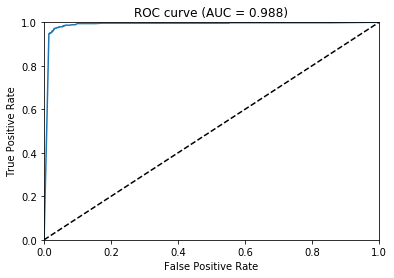

In [22]:
roc_auc, fpr, tpr, rocthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [23]:
for i in range(0,len(fpr), 15):
    print("Threshold {0}, FPR = {1}, TPR = {2}".format(rocthresholds[i], fpr[i], tpr[i]))

Threshold 1.9913461208343506, FPR = 0.0, TPR = 0.0
Threshold 0.7078307271003723, FPR = 0.027416038382453736, TPR = 0.9630314232902033
Threshold 0.49577757716178894, FPR = 0.045236463331048665, TPR = 0.977818853974122
Threshold 0.2894887924194336, FPR = 0.067854694996573, TPR = 0.9870609981515711
Threshold 0.13335753977298737, FPR = 0.10006854009595613, TPR = 0.9944547134935305
Threshold 0.05439990386366844, FPR = 0.17272104180945852, TPR = 0.9963031423290203
Threshold 0.029915643855929375, FPR = 0.24057573680603153, TPR = 0.9963031423290203
Threshold 0.02113678678870201, FPR = 0.35023989033584646, TPR = 0.9963031423290203
Threshold 0.00901866890490055, FPR = 0.4167237834132968, TPR = 0.9963031423290203
Threshold 0.0060461582615971565, FPR = 0.5990404386566142, TPR = 0.9981515711645101
Threshold 0.0035482696257531643, FPR = 0.8567511994516792, TPR = 0.9981515711645101


In [13]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.003159142564982176, recall = 1.0, precision = 0.2771516393442623
Threshold 0.0058912779204547405, recall = 0.9981515711645101, precision = 0.3643724696356275
Threshold 0.008903768844902515, recall = 0.9963031423290203, precision = 0.4473029045643154
Threshold 0.014762496575713158, recall = 0.9963031423290203, precision = 0.49815157116451014
Threshold 0.02688189595937729, recall = 0.9963031423290203, precision = 0.5649895178197065
Threshold 0.03629868105053902, recall = 0.9963031423290203, precision = 0.6478365384615384
Threshold 0.064543716609478, recall = 0.9944547134935305, precision = 0.7339699863574352
Threshold 0.15009774267673492, recall = 0.988909426987061, precision = 0.8057228915662651
Threshold 0.3239760100841522, recall = 0.9852125693160814, precision = 0.8528
Threshold 0.4632239043712616, recall = 0.9796672828096118, precision = 0.8774834437086093
Threshold 0.5960071682929993, recall = 0.9741219963031423, precision = 0.9101899827288429
Threshold 0.73570364713668

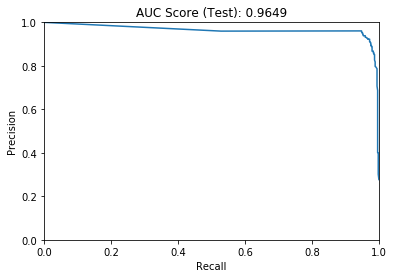

In [14]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 564.3000000000001)

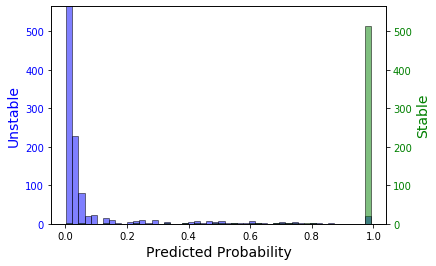

In [15]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

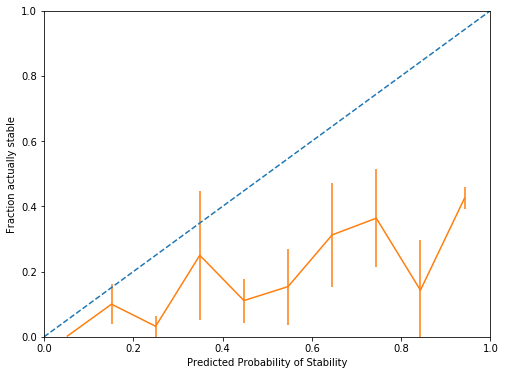

In [16]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

../modelfitting.py:99: RuntimeWarning: divide by zero encountered in true_divide
  errorbars.append(np.sqrt(1./Nerrors + 1./hist[i])*errorfracs[-1]) # see calibration plot comment
../modelfitting.py:99: RuntimeWarning: invalid value encountered in double_scalars
  errorbars.append(np.sqrt(1./Nerrors + 1./hist[i])*errorfracs[-1]) # see calibration plot comment


Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

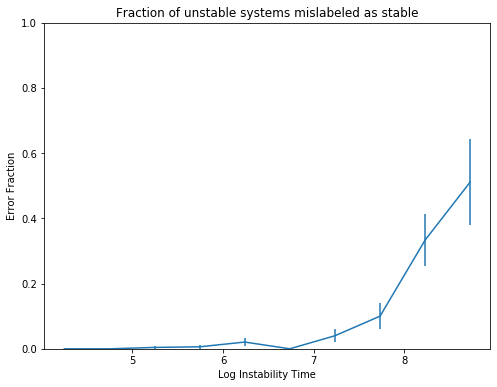

In [17]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

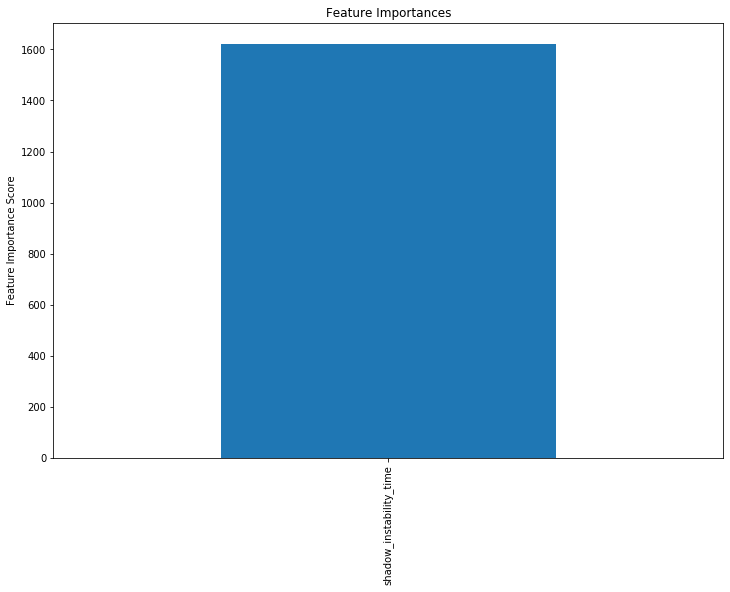

In [18]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [19]:
dill.dump([model, features, featurefolder], open(datapath+"../models/shadowtimesxgb_resonant.pkl", "wb"))